In [78]:
## import packages
import numpy as np
import pandas as pd
from PIL import Image
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import math
from scipy.ndimage import convolve1d
from skimage.metrics import structural_similarity as ssim
from skimage.transform import resize
from typing import List, Tuple, Optional, Dict, Union
from scipy.ndimage import gaussian_filter

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.linear_model import LogisticRegression

plt.rcParams["figure.figsize"] = (20, 8)

In [79]:
def rgb2gray(rgb: np.ndarray) -> np.ndarray:
    """
    Converts RGB images to grayscale.

    Args:
        rgb (np.ndarray): RGB image.

    Returns:
        gray (np.ndarray): Grayscale image.
    """
    r, g, b = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

def plot_pictures(
    imgs: List[np.ndarray],
    xlabels: List[str],
    nrows: int,
    ncols: int,
    show: bool = True,
    cmap: Union[str, List[str]] = "gray",
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
    same_scale: bool = False,
) -> List[plt.Axes]:
    """
    Plots images in a grid.

    Args:
        imgs (list[np.ndarray]): List of images.
        xlabels (list[str]): List of xlabels.
        nrows (int): Number of rows.
        ncols (int): Number of columns.
        show (bool): Whether to show the plot.
        cmap (Union[str, List[str]]): Color map.
        vmin (float): Minimum value.
        vmax (float): Maximum value.
        same_scale (bool): Whether to use the same scale for all images.

    Returns:
        axs (list[matplotlib.axes._subplots.AxesSubplot]): List of axes.
    """

    fig, axs = plt.subplots(nrows, ncols,
                            width_ratios=[img.shape[1] / img.shape[0] for img in imgs],
                            sharey=same_scale,
                            figsize=(ncols * 6, nrows * 6))
    axs = axs.flatten()

    for i, (img, ax) in enumerate(zip(imgs, axs)):
        if isinstance(cmap, list):
            current_cmap = cmap[i]
        else:
            current_cmap = cmap
        im = ax.imshow(img, cmap=current_cmap, vmin=vmin, vmax=vmax)


        ax.set_title(xlabels[i])
        ax.axis('off')
    #plt.tight_layout()

    if show:
        plt.show()
    else:
        return axs

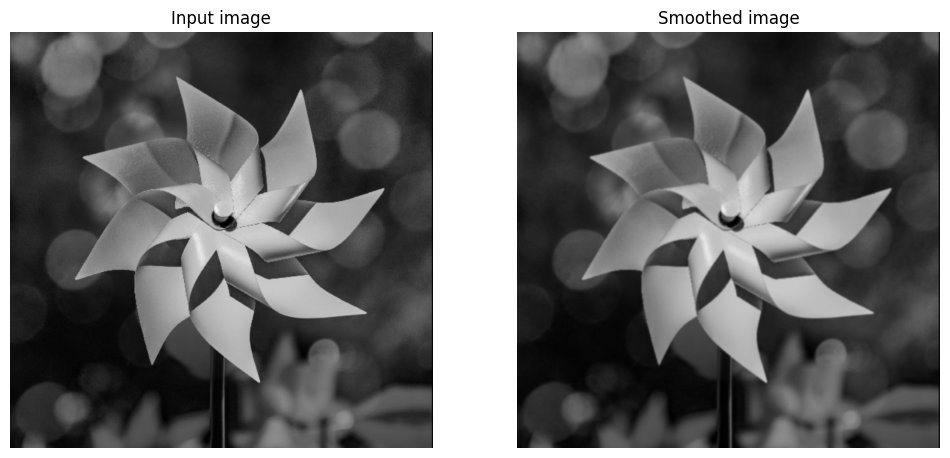

In [80]:
# STEP 1:
img = rgb2gray(np.array(Image.open("images/pinwheel.jpg")))
smoothed_img = gaussian_filter(img, sigma=1)

plot_pictures([img, smoothed_img], ["Input image", "Smoothed image"], 1, 2, vmax=255)

## Canny Edge Detector

### Prewitt Operator

In [340]:
from scipy.ndimage import convolve

def prewitt_x(img: np.ndarray) -> np.ndarray:
    """
    Implement a 3x3 Prewitt discrete operator for vertical edges.

    Args:
        img (np.ndarray): Input image.

    Returns:
        Fx (np.ndarray): Image with vertical edges.
    """

    # Prewitt
    pwt_x = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
    out = convolve(img, pwt_x)

    return out

def prewitt_y(img: np.ndarray) -> np.ndarray:
    """
    Implement a 3x3 Prewitt discrete operator for horizontal edges.

    Args:
        img (np.ndarray): Input image.

    Returns:
        Fx (np.ndarray): Image with horizontal edges.
    """

    # Prewitt
    pwt_y = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
    out = convolve(img, pwt_y)

    return out

# STEP 2
def prewitt_filters(img: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    This function applies the prewitt filter to the input image in x and y direction.
    Scale' the magnitude to [0, 255] and return the magnitude and the direction of the gradient.

    Args:
        img (np.ndarray): input image

    Returns:
        G (np.ndarray): gradient magnitude
        theta (np.ndarray): gradient direction
    """

    Gx = prewitt_x(img)
    Gy = prewitt_y(img)
    G = np.sqrt(Gx**2 + Gy**2)

    # Scaling of G
    G = 255 * (G - G.min()) / (G.max() - G.min())
    
    theta = np.arctan2(Gy, Gx)

    return (G, theta)

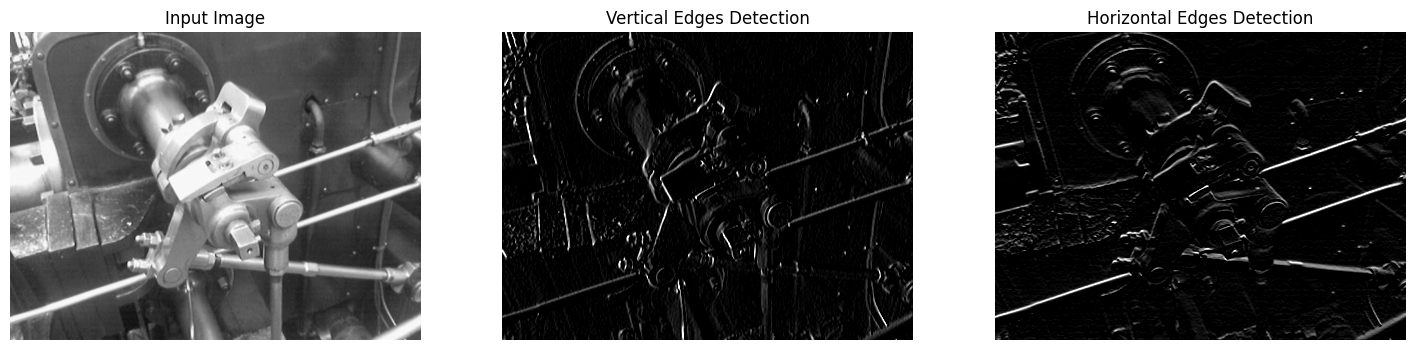

In [341]:
img = rgb2gray(np.array(Image.open("images/valve.png")))
imgs = [img, prewitt_x(img), prewitt_y(img)]
labels = ["Input Image", "Vertical Edges Detection", "Horizontal Edges Detection"]
plot_pictures(imgs, labels, nrows=1, ncols=3, cmap="gray", vmin=0, vmax=255)

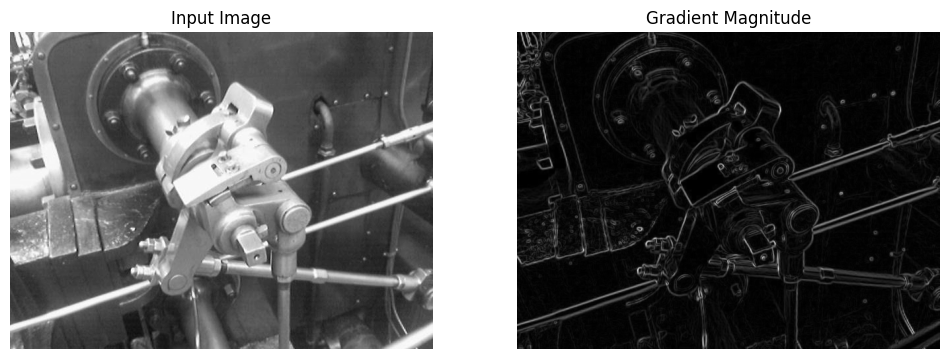

In [342]:
img = rgb2gray(np.array(Image.open("images/valve.png")))
igms = [img, prewitt_filters(img)[0]]
labels = ["Input Image", "Gradient Magnitude"]
plot_pictures(igms, labels, nrows=1, ncols=2, cmap="gray", vmin=0, vmax=255)

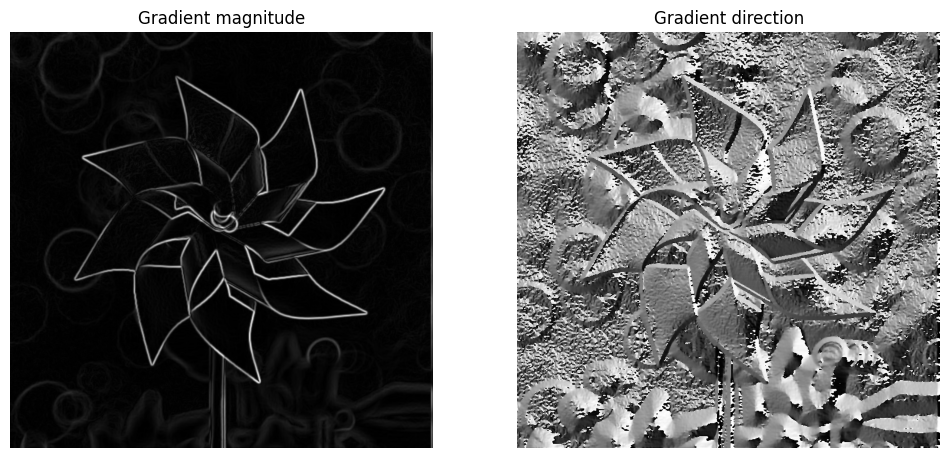

In [343]:
G, theta = prewitt_filters(smoothed_img)

plot_pictures([G, theta], ["Gradient magnitude", "Gradient direction"], 1, 2)

In [344]:
import numpy as np
import plotly.graph_objs as go

def plot_gradients_3d(G: np.ndarray, theta: np.ndarray, step: int = 5) -> None:
    """
    Plot the gradient magnitude and directions in a 3D plot using plotly.

    Args:
        G (np.ndarray): Gradient magnitude (height in 3D).
        theta (np.ndarray): Gradient direction in radians.
        step (int): Step size to reduce the number of arrows plotted (for better clarity).
    """
    # Get the dimensions of the image
    rows, cols = G.shape

    # Create a meshgrid for X, Y coordinates
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))

    # Sampling the gradient data to avoid too many arrows on the plot
    x = x[::step, ::step]
    y = y[::step, ::step]
    G_sampled = G[::step, ::step]
    theta_sampled = theta[::step, ::step]

    # Compute Gx and Gy from theta for the quiver plot
    Gx = np.cos(theta_sampled) * G_sampled
    Gy = np.sin(theta_sampled) * G_sampled

    # Create a 3D surface plot for the gradient magnitude
    surface = go.Surface(z=G, x=np.arange(cols), y=np.arange(rows),
                         colorscale='Viridis', showscale=True)

    # Create a 3D quiver plot to represent gradient directions using scatter3d for arrows
    quiver = go.Cone(
        x=x.ravel(),  # X coordinates for the arrow base
        y=y.ravel(),  # Y coordinates for the arrow base
        z=G_sampled.ravel(),  # Z coordinates for the arrow base (height)
        u=Gx.ravel(),  # X direction of the arrow (Gx)
        v=Gy.ravel(),  # Y direction of the arrow (Gy)
        w=np.zeros_like(G_sampled.ravel()),  # No Z movement for arrows (arrows stay in XY plane)
        sizemode='absolute',  # Set fixed arrow size for better clarity
        sizeref=2,  # Adjust this to control the size of the arrows
        showscale=True,
        colorscale='Blues'
    )

    # Create the layout with a bigger size and quadratic shape
    layout = go.Layout(
        title="3D Gradient Magnitude and Directions",
        autosize=False,
        width=1000,  # Increase width for bigger image
        height=1000,  # Increase height for a more quadratic shape
        scene=dict(
            aspectmode='cube',  # Make the plot cubic
            xaxis=dict(title='X', range=[0, cols], nticks=10),
            yaxis=dict(title='Y', range=[0, rows], nticks=10),
            zaxis=dict(title='Gradient Magnitude (G)', nticks=10),
        )
    )

    # Plot the surface and quiver together
    fig = go.Figure(data=[surface, quiver], layout=layout)
    fig.show()

# Example usage assuming you have G and theta already calculated
if __name__ == "__main__":

    # Example: Compute G and theta using the provided prewitt_filters function
    G, theta = sobel_filters(smoothed_img)

    # Plot the gradient field in 3D
    plot_gradients_3d(G, theta, step=5)



NameError: name 'sobel_filters' is not defined

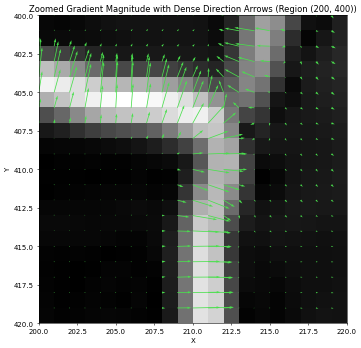

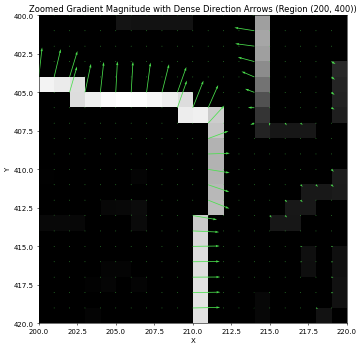

In [345]:
from typing import Tuple


def plot_gradient_field_2d_zoom(G: np.ndarray, theta: np.ndarray, step: int = 5, scale: int = 150, 
                                 zoom_start: Tuple[int, int] = (30, 30), zoom_size: Tuple[int, int] = (40, 40), 
                                 arrow_length: float = 0.17) -> None:
    """
    Plot the gradient magnitude as a 2D image, zoomed in to a specific region, with smaller, denser red arrows
    showing the direction of the gradient vectors.

    Args:
        G (np.ndarray): Gradient magnitude.
        theta (np.ndarray): Gradient direction in radians.
        step (int): Step size to control the density of arrows.
        scale (int): Scale factor to control the size of the arrows.
        zoom_start (Tuple[int, int]): Starting (x, y) coordinates for the zoomed-in region.
        zoom_size (Tuple[int, int]): Width and height of the zoomed-in region.
        arrow_length (float): Factor to scale the length of the arrows.
    """
    # Ensure theta is in the range [0, pi]
    #theta = np.abs(theta)

    # Get zoom start and size
    x_start, y_start = zoom_start
    width, height = zoom_size

    # Crop the gradient and theta to the zoomed region
    G_zoomed = G[y_start:y_start + height, x_start:x_start + width]
    theta_zoomed = theta[y_start:y_start + height, x_start:x_start + width]

    # Create a meshgrid for X, Y coordinates in the zoomed region
    rows, cols = G_zoomed.shape
    x, y = np.meshgrid(np.arange(0, cols, step), np.arange(0, rows, step))

    # Sample the gradient magnitude and theta at the grid points
    G_sampled = G_zoomed[::step, ::step]
    theta_sampled = theta_zoomed[::step, ::step]

    # Calculate the x and y components of the gradient using theta
    Gx = np.cos(theta_sampled) * G_sampled * arrow_length  # Normalize arrow length
    Gy = np.sin(theta_sampled) * G_sampled * arrow_length  # Normalize arrow length

    # Create the plot
    plt.figure(figsize=(8, 8), dpi=50)
    
    # Plot the cropped gradient magnitude as a 2D image (background)
    plt.imshow(G_zoomed, cmap='gray', origin='upper', extent=(x_start, x_start + cols, y_start + rows, y_start))
    
    # Overlay the quiver (red arrows showing gradient direction in zoomed region)
    plt.quiver(x_start + x, y_start + y, Gx, Gy, color='#4ae04d', scale=scale, width=0.0025)  # Smaller arrows

    plt.title(f"Zoomed Gradient Magnitude with Dense Direction Arrows (Region {zoom_start})")
    plt.xlabel("X")
    plt.ylabel("Y")
    
    # Display the plot
    plt.show()


# Example usage assuming you have G and theta already calculated
if __name__ == "__main__":
    # Generate some test data (replace with your real G and theta values)
    img = np.random.rand(100, 100) * 255  # Example image

    # Example: Compute G and theta using the provided prewitt_filters function
    G, theta = prewitt_filters(smoothed_img)  # Assuming you have implemented this function

    # Plot the gradient field with zoom on a specific region of the image
    plot_gradient_field_2d_zoom(G, -theta, step=1, scale=300, zoom_start=(200, 400), zoom_size=(20, 20))

    # Example: Compute G and theta using the provided prewitt_filters function
    G, theta = prewitt_filters(smoothed_img)  # Assuming you have implemented this function

    Z = non_max_suppression(G, theta)
    plot_gradient_field_2d_zoom(Z, -theta, step=1, scale=300, zoom_start=(200, 400), zoom_size=(20, 20))

### Non-maximum Suppression

In [352]:
def direction_scan(
    img: np.ndarray, theta: np.ndarray, i:int, j:int
    ) -> List[float]:
    """
    This function quantizes the gradient directions into
    four discrete directions:
        - horizontal: theta in [0, 45) or [135, 180]
        - right diagonal: theta in [0, 45)
        - vertical: theta in [45, 135)
        - left diagonal: theta in [135, 180)
    then it returns the pixel values of the two pixels in
    the corresponding direction.

    Returns:
        neighbors List[float]: pixel values of the two neighbors
            in the corresponding direction
    """

    theta = theta * 180 / np.pi

    #####################################################
    ##            FIX THIS CODE (8 ERRORS)             ##
    #####################################################
    if (0 <= theta[i,j] < 22.5) or (157.5 < theta[i,j] <= 180):
        neighbors = [(i, j-1), (i, j+1)]
    elif (22.5 <= theta[i,j] < 67.5):
        neighbors = [(i-1, j+1), (i+1, j-1)]
    elif (65.5 <= theta[i,j] < 112.5):
        neighbors = [(i-1, j), (i+1, j)]
    else:
        neighbors = [(i-1, j-1), (i+1, j+1)]

    # Get the pixel values of the neighbors
    pixels = [img[x,y] for x, y in neighbors]

    return pixels

def non_max_suppression(img: np.ndarray, D: np.ndarray) -> np.ndarray:
    """
    This function performs non-maximum suppression on the input image.

    Args:
        img (np.ndarray): input image
        D (np.ndarray): gradient direction

    Returns:
        Z (np.ndarray): image after non-maximum suppression
    """

    M, N = img.shape
    Z = np.zeros((M, N), dtype=np.uint8)

    theta = np.rad2deg(D)
    #theta[theta < 0] += 180

    for i in range(1, M - 1):
        for j in range(1, N - 1):
            # Get pixel value
            current_pixel = img[i, j]

            # Get neighbors in the gradient direction
            
            if (0 <= theta[i,j] < 22.5) or (157.5 < theta[i,j] <= 180):
                neighbors = [(i, j-1), (i, j+1)]
            elif (22.5 <= theta[i,j] < 67.5):
                neighbors = [(i-1, j-1), (i+1, j+1)]#[(i-1, j+1), (i+1, j-1)]
            elif (65.5 <= theta[i,j] < 112.5):
                neighbors = [(i-1, j), (i+1, j)]
            else:
                neighbors = [(i-1, j+1), (i+1, j-1)]#[(i-1, j-1), (i+1, j+1)]

            # Get the pixel values of the neighbors
            neighbors = [img[x,y] for x, y in neighbors]

            # Suppress the current pixel if it is not the maximum
            if current_pixel >= max(neighbors, default=-1):  # default=-1 in case neighbors list is empty
                Z[i, j] = current_pixel
            else:
                Z[i, j] = 0

    return (Z / Z.max() * 255).astype(np.uint8)

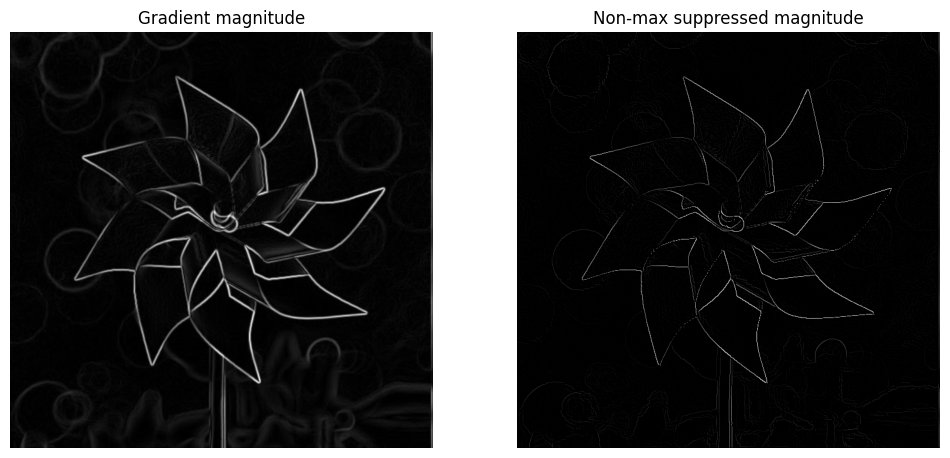

In [353]:
#Z = nonmaximum_suppression_bilinear(G, theta)
Z = non_max_suppression(G, theta)

plot_pictures(
    [G, Z],
    ["Gradient magnitude", "Non-max suppressed magnitude"],
    1,
    2,
)

### Tresholding

In [348]:
# STEP 4
def threshold(
    img: np.ndarray,
    low_threshold: int = 100, high_threshold: int = 200,
    weak_value :int = 100, strong_value: int = 255
) -> np.ndarray:
    """
    This function applies a double thresholding to the input image.

    Args:
        img (np.ndarray): input image
        low_threshold (int): low threshold
        high_threshold (int): high threshold
        weak_value (int): value for weak edges
        strong_value (int): value for strong edges

    Returns:
        res (np.ndarray): thresholded image
    """

    i_height, i_width = img.shape
    res = np.zeros((i_height, i_width), dtype=np.uint8)
    
    for i in range(1, i_height - 1):
        for j in range(1, i_width - 1):
            if img[i, j] < low_threshold:
                res[i, j] = 0
            elif img[i, j] > high_threshold:
                res[i, j] = strong_value
            else:
                res[i, j] = weak_value

    return res

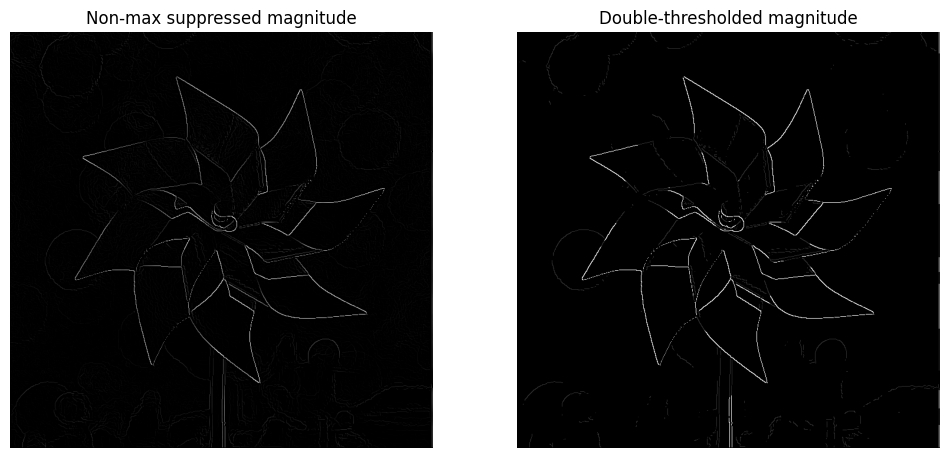

In [349]:
weak_value = 50
strong_value = 255
res = threshold(Z, low_threshold=25, high_threshold=100, weak_value=weak_value, strong_value=strong_value)

plot_pictures(
    [Z, res],
    ["Non-max suppressed magnitude", "Double-thresholded magnitude"],
    1,
    2,
)

### Hysteresis

In [350]:
def hysteresis1(img: np.ndarray, weak: int = 100, strong: int = 255) -> np.ndarray:
    """
    This function applies hysteresis to the input image.

    Args:
        img (np.ndarray): Input image with edge detection.
        weak (int): Value representing weak edges.
        strong (int): Value representing strong edges.

    Returns:
        np.ndarray: Image after hysteresis thresholding.
    """
    M, N = img.shape
    img_ = img.copy()

    # Find coordinates of strong edges
    strong_edges_idxs = np.argwhere(img_ == strong).tolist()

    # Define the neighborhood for 8-connected pixels
    directions = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]

    # Process each strong edge pixel
    while len(strong_edges_idxs) > 0:
        i, j = strong_edges_idxs.pop()

        # Check all 8-connected neighbors
        for di, dj in directions:
            ni, nj = i + di, j + dj

            # Ensure the neighbor pixel is within the image bounds
            if 0 <= ni < M and 0 <= nj < N:
                # If the neighboring pixel is a weak edge, make it strong and add to the stack
                if img_[ni, nj] == weak:
                    img_[ni, nj] = strong
                    strong_edges_idxs.append((ni, nj))

    # Set all non-strong pixels to 0
    img_[img_ != strong] = 0
    return img_

# STEP 5
def hysteresis(img: np.ndarray, weak: int = 100, strong: int = 255) -> np.ndarray:
    """
    This function applies hysteresis to the input image.

    Args:
        img (np.mdarray): input image.
        weak (int): weak threshold.
        strong (int): strong threshold.

    Returns:
        img (np.ndarray): image after hysteresis.
    """
    M, N = img.shape
    img_ = img.copy()
    strong_edges_idxs = np.argwhere(img == strong).tolist()
    while len(strong_edges_idxs) > 0:
        i, j = strong_edges_idxs.pop()
        if (i - 1 >= 0) and (j - 1 >= 0) and (i + 1 < M) and (j + 1 < N):
            weak_edges_mask = img_[i - 1 : i + 2, j - 1 : j + 2] == weak
            if np.any(weak_edges_mask):
                img_[i - 1 : i + 2, j - 1 : j + 2][weak_edges_mask] = strong
                weak_edges_idxs = (
                    (np.argwhere(weak_edges_mask) - 1) + np.array([i, j])
                ).tolist()
                strong_edges_idxs = strong_edges_idxs + weak_edges_idxs[::-1]
    img_[img_ != strong] = 0
    return img_

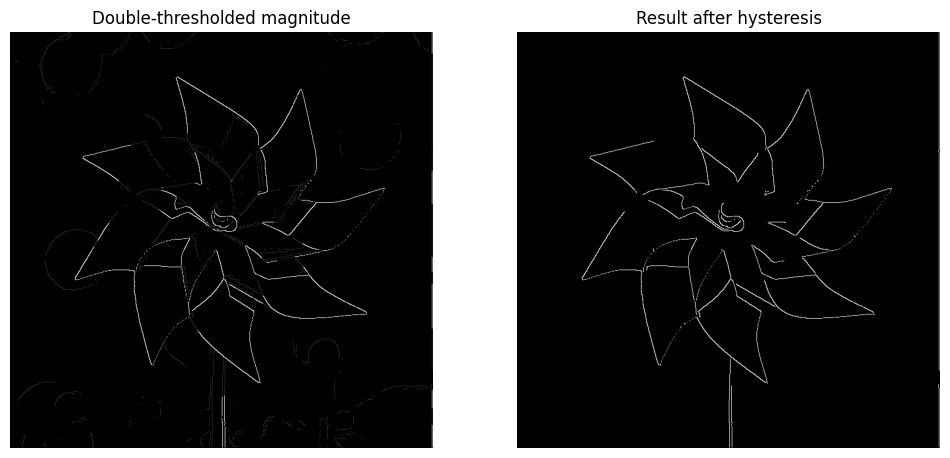

In [351]:
final_img = hysteresis(res, weak=weak_value)

plot_pictures(
    [res, final_img],
    ["Double-thresholded magnitude", "Result after hysteresis"],
    1,
    2,
)

In [145]:
def canny_edge_detector(
    img: np.ndarray, sigma: int = 1,
    low_threshold: int = 50, high_threshold: int = 100
) -> np.ndarray:
    """
    This function implements the Canny edge detector.
    Put together the previous functions to implement the
    Canny edge detector.
    Don't apply the gaussian filter if sigma=0.

    Args:
        img (np.ndarray): input image
        sigma (int): standard deviation for the gaussian filter;
            if sigma=0, no gaussian filter is applied
        low_threshold (int): low threshold
        high_threshold (int): high threshold

    Returns:
        out_img (np.ndarray): image after applying the Canny edge
            detector
    """

    # Step 1 : Smooth the image
    if sigma != 0:
        smoothed_img = gaussian_filter(img, sigma)
    else:
        smoothed_img = img

    # Step 2 : Compute the gradient
    G, theta = prewitt_filters(smoothed_img)

    plot_pictures(
        [G, G],
        ["Gradient magnitude", "Gradient direction"],
        1,
        2,
    )

    # Step 3 : Non-maximum suppression
    Z = non_max_suppression(G, theta)

    plot_pictures(
        [Z, Z],
        ["Non-max suppressed magnitude", "Non-max suppressed direction"],
        1,
        2,
    )

    # Step 4 : Double threshold
    out_img = threshold(Z, low_threshold=low_threshold, high_threshold=high_threshold, weak_value=100, strong_value=255)

    plot_pictures(
        [out_img, out_img],
        ["Double-thresholded magnitude", "Double-thresholded direction"],
        1,
        2,
    )

    # Step 5 : Hysteresis

    out_img = hysteresis(out_img, weak=100)

    plot_pictures(
        [out_img, out_img],
        ["Result after hysteresis", "Result after hysteresis"],
        1,
        2,
    )

    return out_img

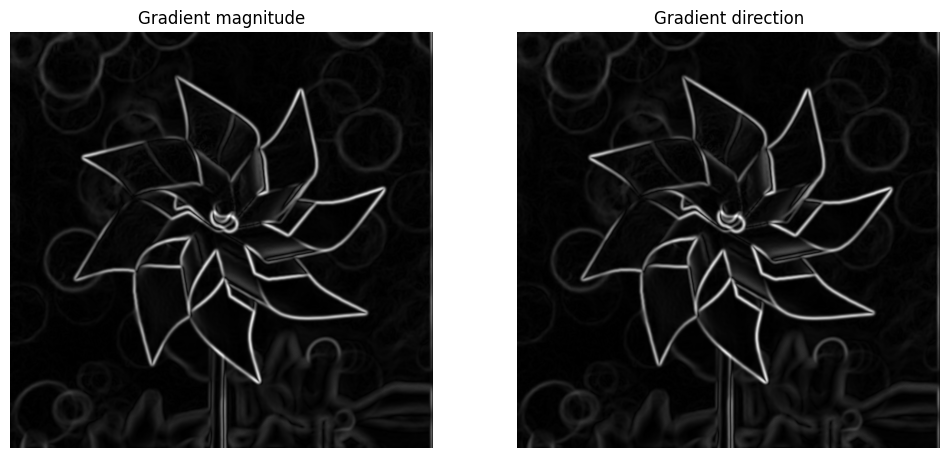

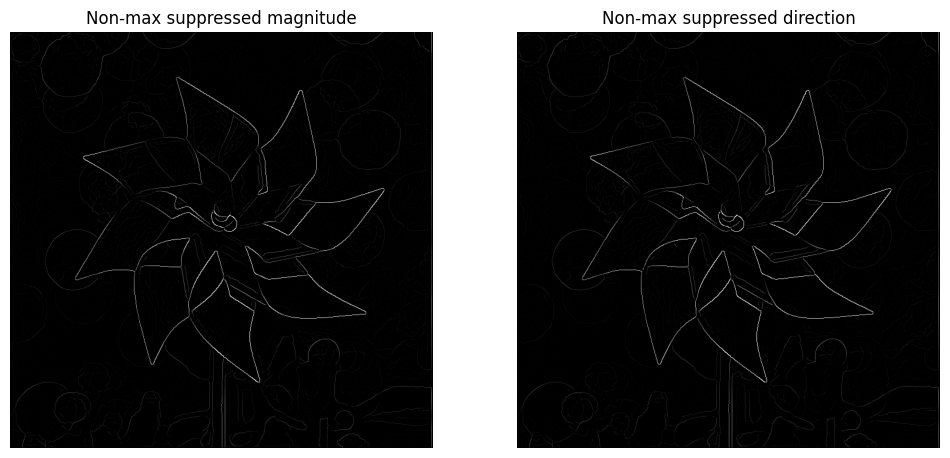

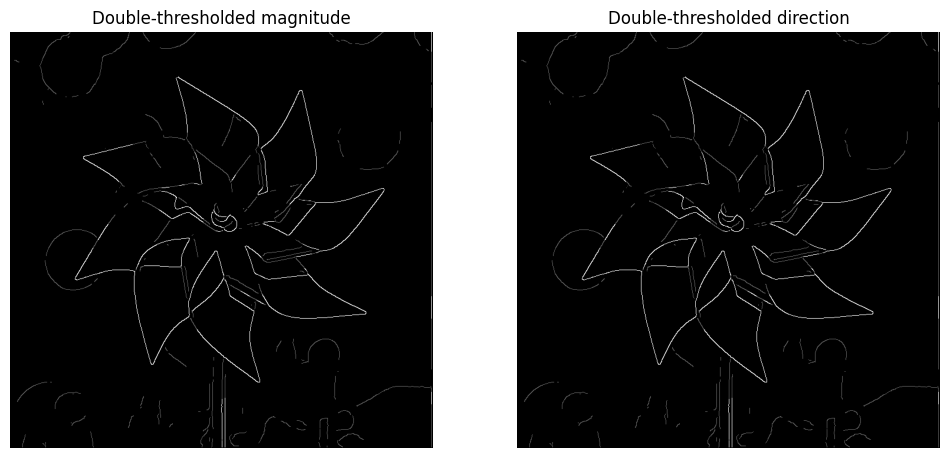

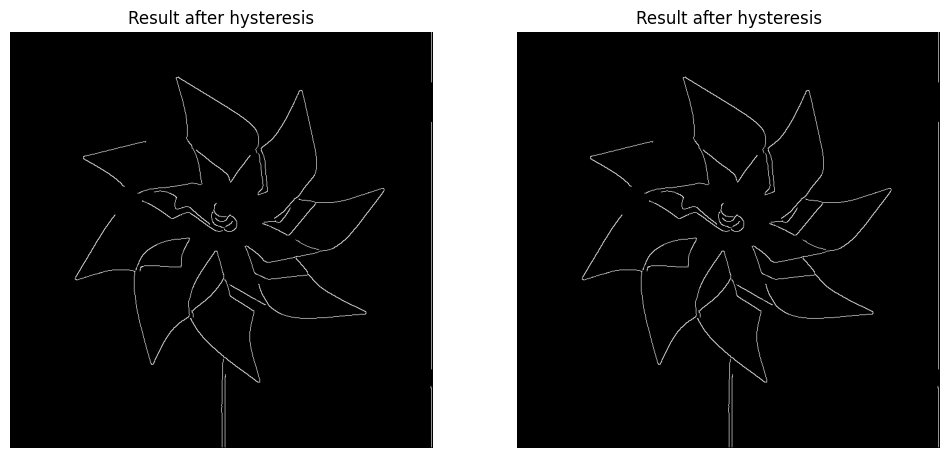

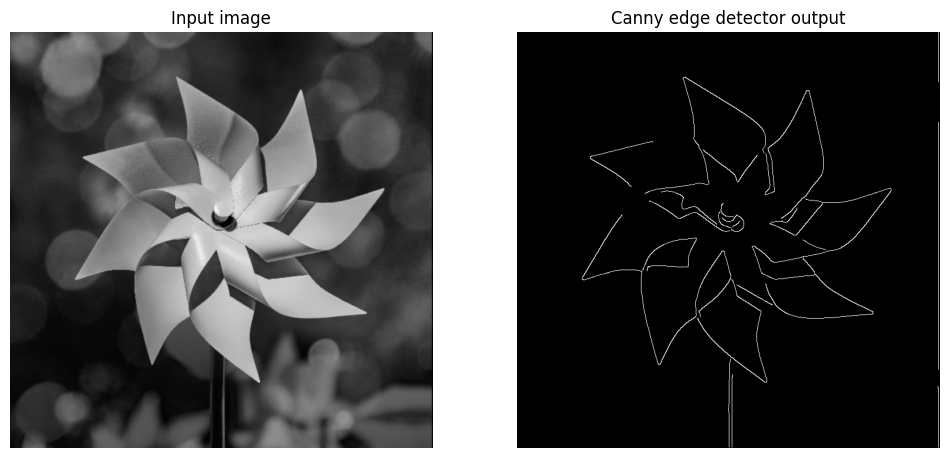

In [146]:
img = rgb2gray(np.array(Image.open("images/pinwheel.jpg")))
out_img = canny_edge_detector(img, sigma=2, low_threshold=35, high_threshold=100)

plot_pictures(
    [img, out_img],
    ["Input image", "Canny edge detector output"],
    1,
    2,
)

In [147]:
def jaccard(patch:np.ndarray,template:np.ndarray) -> float:
    """
    This function computes the Jaccard similarity between
    two images.

    Args:
        patch (np.array): patch of the input image
        template (np.array): template to match

    Returns:
        jaccard_score (float)
    """
    
    # Flatten arrays (if needed)
    patch_flat = patch.flatten()
    template_flat = template.flatten()

    # Calculate intersection and union using logical operations
    intersection = np.logical_and(patch_flat, template_flat).sum()
    union = np.logical_or(patch_flat, template_flat).sum()

    # Avoid division by zero
    if union == 0:
        return 0.0

    # Calculate Jaccard score
    jaccard_score = intersection / union

    return jaccard_score

def match_template(
    img: np.ndarray, template: np.ndarray
) -> Tuple[np.ndarray, Tuple[int, int]]:
    """
    This function implements the template matching algorithm.

    Args:
        img (np.ndarray): input image.
        template (np.array): template to match.

    Returns:
        img_score (np.ndarray): metric scores after applying the template matching algorithm.
        best_match_idxs (tuple): index of the best match.
    """
    t_height, t_width = template.shape
    i_height, i_width = img.shape
    assert (i_height >= t_height) and (
        i_width >= t_width
    ), f"Cannot match template of shape {template.shape} with image of shape {img.shape}"
    img_score = np.zeros((i_height - t_height + 1, i_width - t_width + 1))


    for i in range(0, i_height - t_height + 1):
        for j in range(0, i_width - t_width + 1):
            img_score[i, j] = jaccard(img[i : i + t_height, j : j + t_width], template)
    

    best_match_idxs = np.unravel_index(img_score.argmax(), img_score.shape)

    return img_score, best_match_idxs

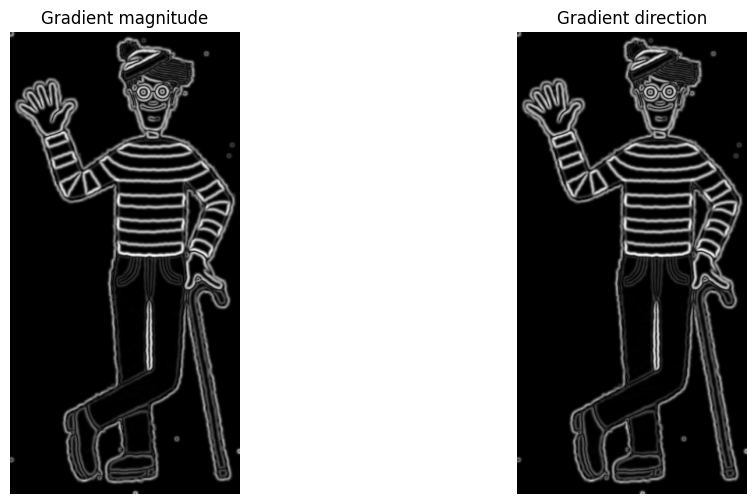

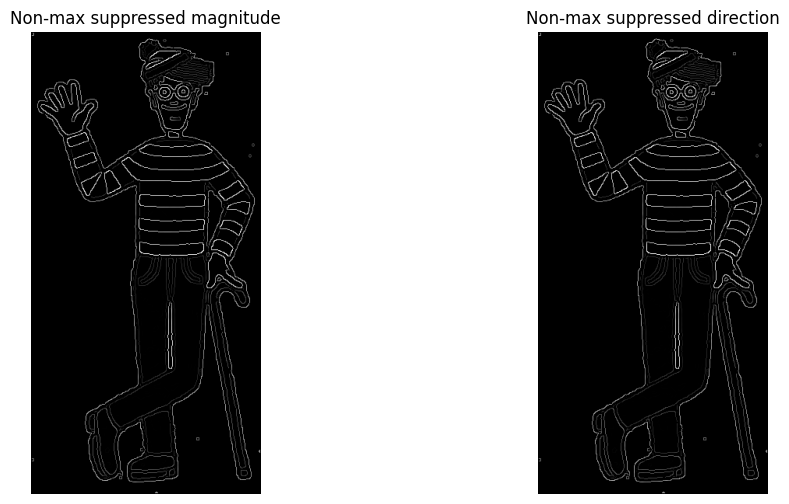

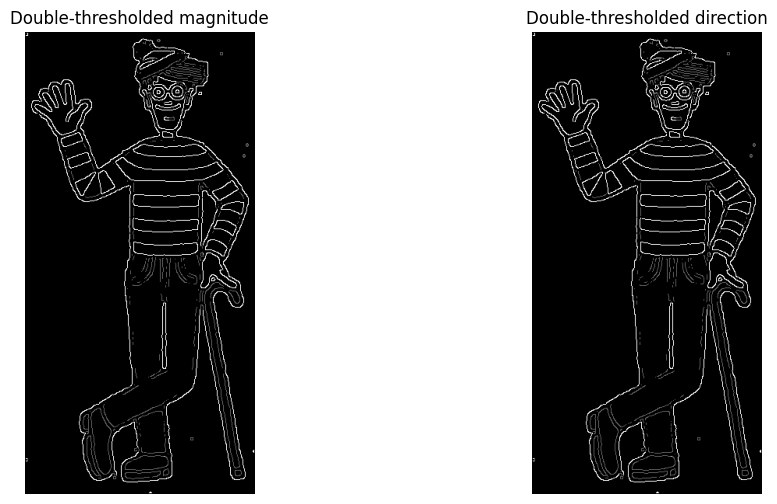

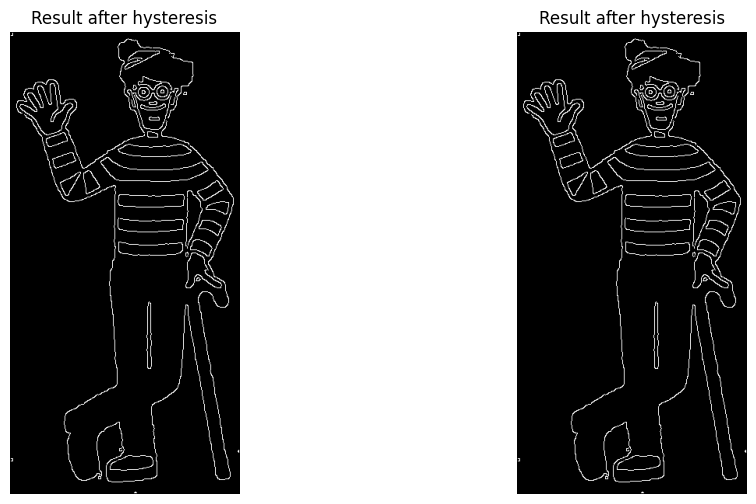

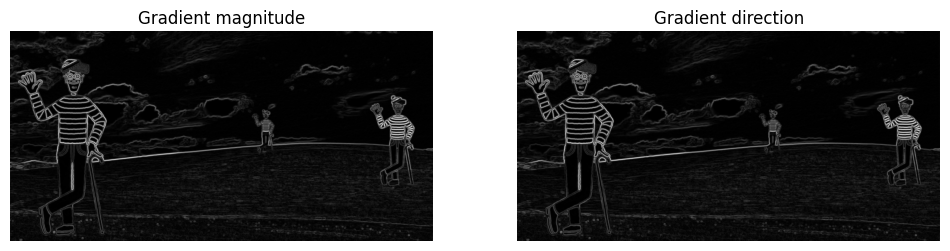

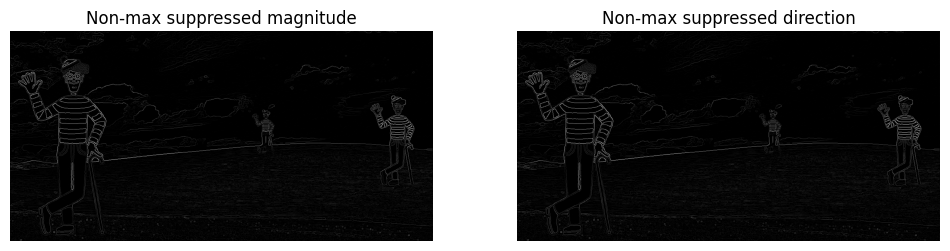

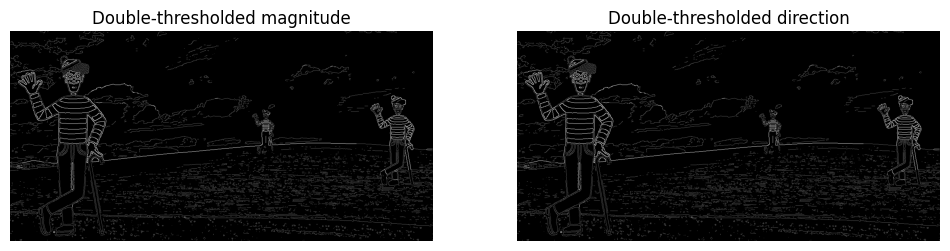

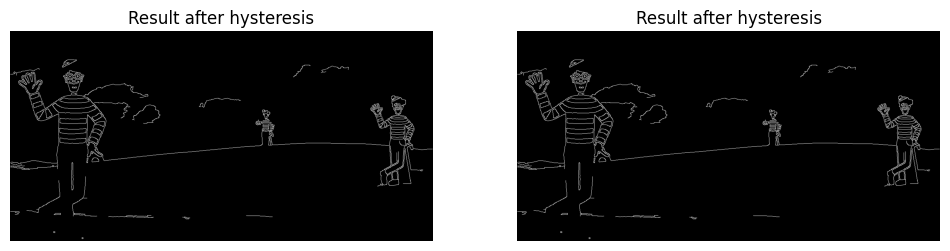

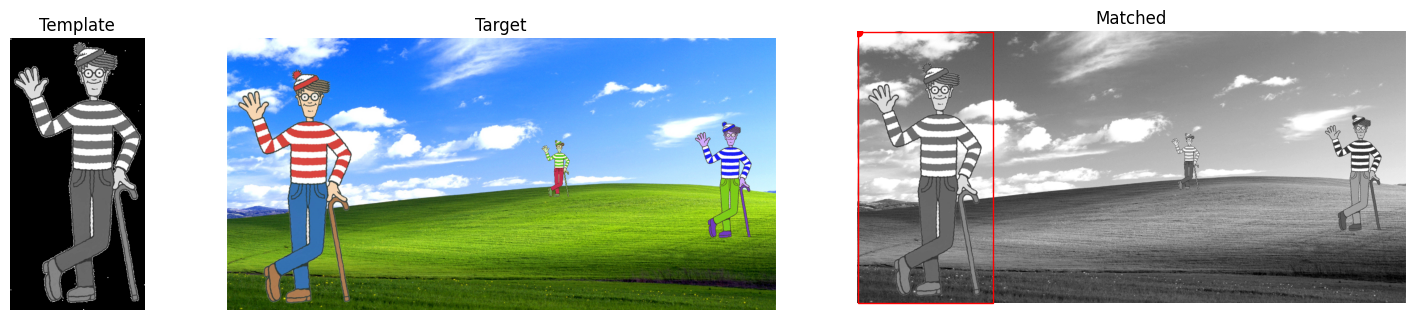

In [148]:
import matplotlib.patches as patches

img_1 = rgb2gray(np.array(Image.open("images/wally.jpg")))
img_2 = rgb2gray(np.array(Image.open("images/findwally.jpg")))

template = canny_edge_detector(img_1, sigma=1.5, low_threshold=40, high_threshold=100)
target = canny_edge_detector(img_2, sigma=1, low_threshold=25, high_threshold=100)

imgs = [img_1, np.array(Image.open("images/findwally.jpg")), img_2]
xlabels = ["Template", "Target", "Matched"]
axs = plot_pictures(imgs, xlabels, 1, 3, show=False, vmin=None, vmax=None)
img_score, best_match = match_template(target, template)

axs[-1].plot(best_match[1], best_match[0], "ro")
axs[-1].add_patch(
    patches.Rectangle(
        (best_match[1], best_match[0]),
        template.shape[1],
        template.shape[0],
        linewidth=1,
        edgecolor="r",
        facecolor="none",
    )
)

plt.show()

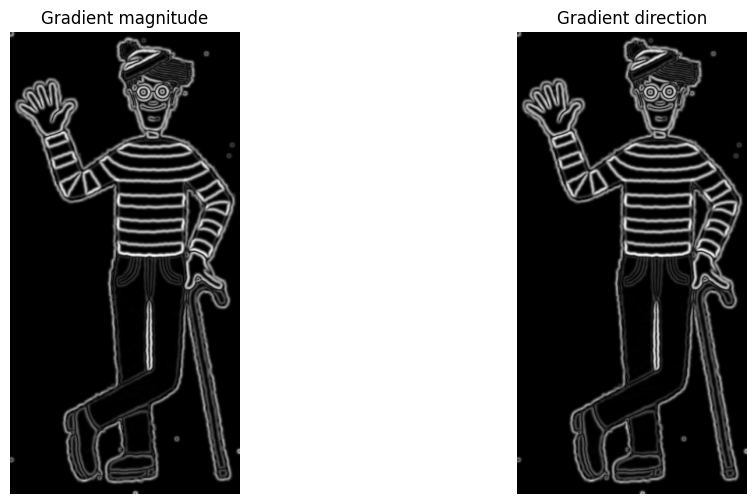

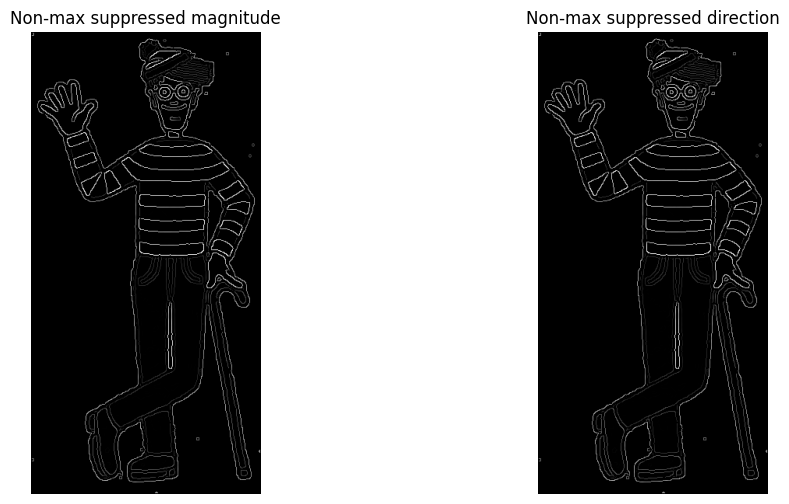

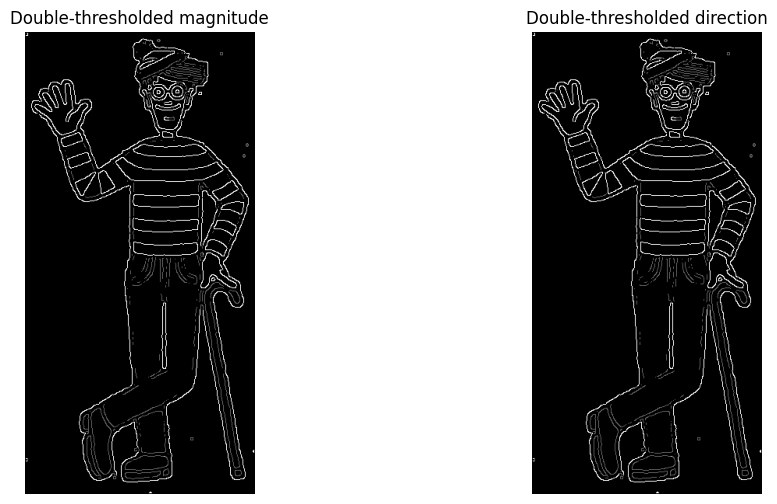

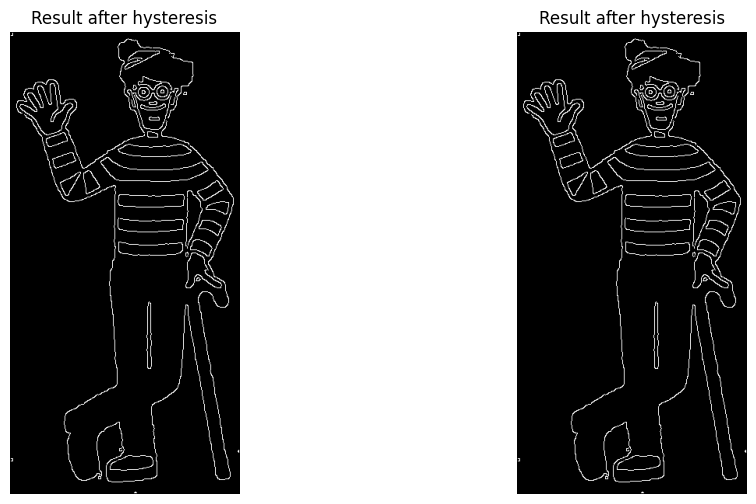

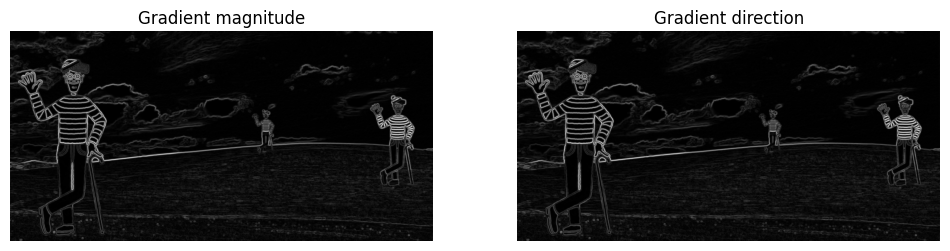

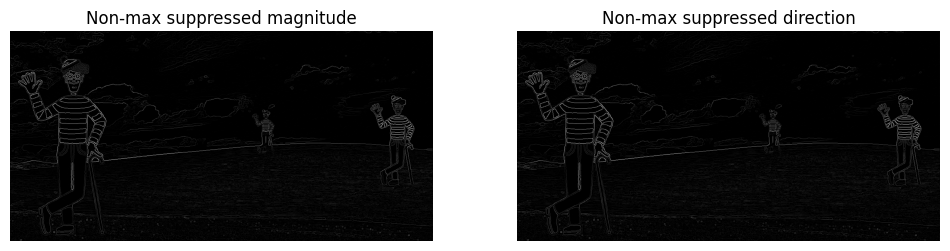

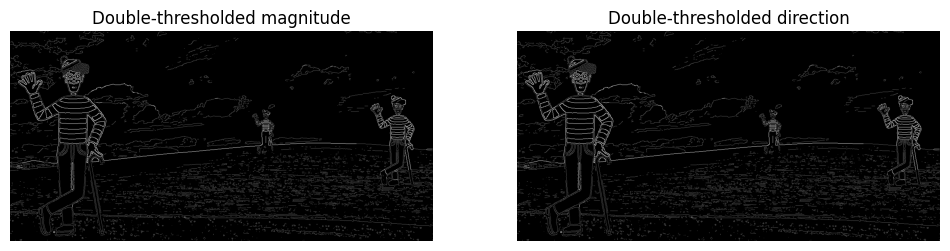

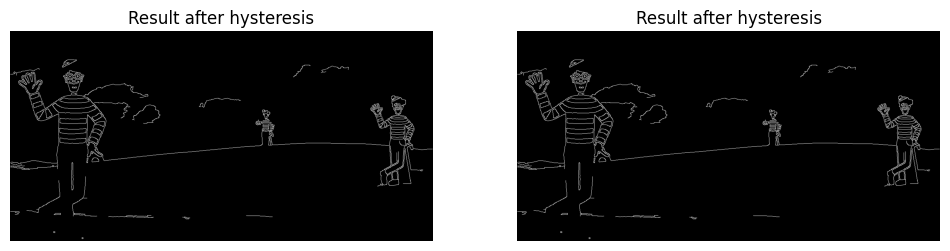

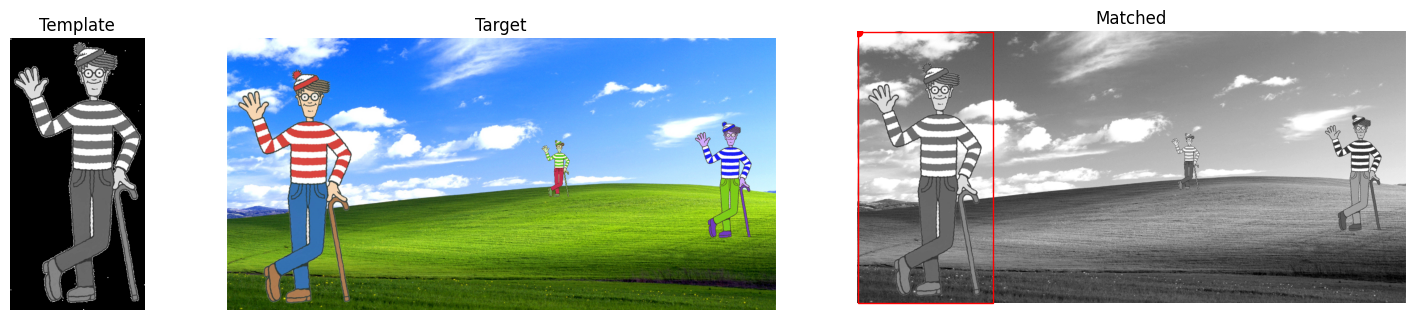

In [149]:
import matplotlib.patches as patches

img_1 = rgb2gray(np.array(Image.open("images/wally.jpg")))
img_2 = rgb2gray(np.array(Image.open("images/findwally.jpg")))

template = canny_edge_detector(img_1, sigma=1.5, low_threshold=40, high_threshold=100)
target = canny_edge_detector(img_2, sigma=1, low_threshold=25, high_threshold=100)

imgs = [img_1, np.array(Image.open("images/findwally.jpg")), img_2]
xlabels = ["Template", "Target", "Matched"]
axs = plot_pictures(imgs, xlabels, 1, 3, show=False, vmin=None, vmax=None)
img_score, best_match = match_template(target, template)

axs[-1].plot(best_match[1], best_match[0], "ro")
axs[-1].add_patch(
    patches.Rectangle(
        (best_match[1], best_match[0]),
        template.shape[1],
        template.shape[0],
        linewidth=1,
        edgecolor="r",
        facecolor="none",
    )
)

plt.show()

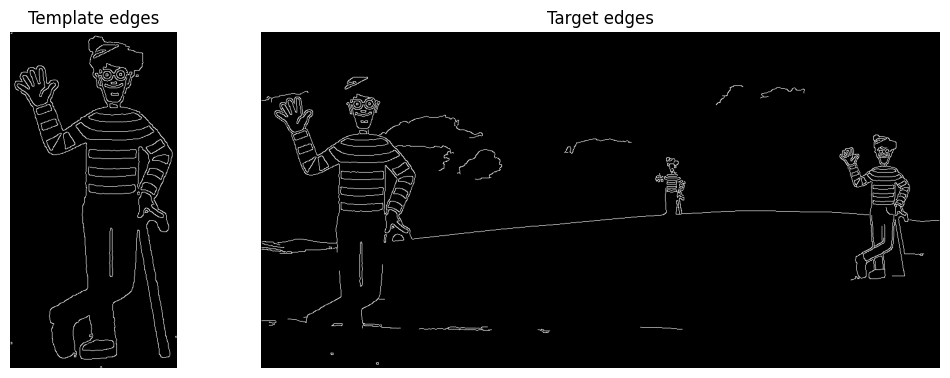

In [150]:
imgs = [template, target]
xlabels = ["Template edges", "Target edges"]
plot_pictures(imgs, xlabels, 1, 2, show=True, cmap="gray", same_scale=True)

In [151]:
def downscale(
    img: np.ndarray,
    factor: float,
    steps:int=3,
    sigma:int=1
    ) -> np.ndarray:
    """
    Iteratively apply a gaussian blur to avoid aliasing
    and then downscale the input image by the given factor.

    Args:
        img (np.ndarray): Input image.
        factor (float): Resizing factor, how may times smaller
            is the image going to be.
        steps(int): the number of times to repeat the iteration.
        sigma (float): Standard deviation for the Gaussian filter.

    Returns:
        imgs (list): list of downscaled images. Each one is
            "factor" times smaller then the previous.
        blurred (list): list of blurred images produced in
            the downscaling process.
    """
    imgs = [img]
    blurred = []

    for _ in range(steps):
        # Apply Gaussian blur to the image to avoid aliasing
        blurred_img = gaussian_filter(imgs[-1], sigma=sigma)
        blurred.append(blurred_img)
        
        # Compute the new size for downscaling
        new_shape = (blurred_img.shape[0] // factor, 
                     blurred_img.shape[1] // factor)
        
        # Resize the blurred image
        downscaled_img = resize(blurred_img, new_shape, anti_aliasing=False)
        imgs.append(downscaled_img)

    return imgs, blurred

In [152]:
def multi_scale_match_template(
    img: np.ndarray,
    template: np.ndarray,
    steps: int,
    sigma: float = 1,
    low_threshold: int = 30,
    high_threshold: int = 70,
) -> List[Dict[str, Union[np.ndarray, Tuple[int, int]]]]:
    """
    This function implements the multi-scale template matching.

    Args:
        img (np.ndarray): input image.
        template (np.ndarray): template image.
        steps (int): number of steps for the Pyramid.
        sigma (float): the Gaussian filter parameter.
        low_threshold (int): low threshold for Canny edge detector.
        high_threshold (int): high threshold for Canny edge detector.

    Returns:
        out: list of dictionaries containing:
            img_score (np.ndarray): score image.
            result (Tuple[int, int]): best match coordinates.
            template (np.ndarray): template image.
    """

    score_results = []
    templates = []

    # Downscale the template with gradual Gaussian blurring
    downscaled_templates, downscaled_templates_blurred = downscale(template, factor=2, steps=steps, sigma=sigma)

    # Apply Canny edge detection on the original image
    img_edges = canny_edge_detector(img, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold)#feature.canny(img, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold)#canny_edge_detector(img, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold)

    import time

    
    for step, scaled_template in enumerate(downscaled_templates):
        print(f"Step {step}: Template Shape = {scaled_template.shape}")

        # Apply Canny edge detection on the scaled template
        template_edges = canny_edge_detector(scaled_template, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold)
        
        # Perform template matching
        start_time = time.time()  # Track the time
        img_score, best_match_idxs = match_template(img_edges, template_edges)
        print(f"Step {step}: Time for matching = {time.time() - start_time:.2f} seconds")
        
        # Plot the image edges and the template edges for this step
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(img_edges, cmap='gray')
        axes[0].set_title(f"Image Edges (Step {step})")
        axes[1].imshow(template_edges, cmap='gray')
        axes[1].set_title(f"Template Edges (Step {step})")
        plt.show()  # Display the plot

        # Append results for each scale
        score_results.append((img_score, best_match_idxs))
        templates.append(scaled_template)

    # Format output as a list of dictionaries
    out = [
        {"img_score": score, "result": result, "template": t}
        for (score, result), t in zip(score_results, templates)
    ]

    return out

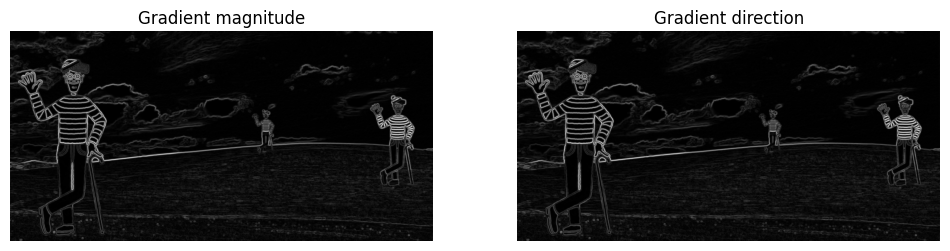

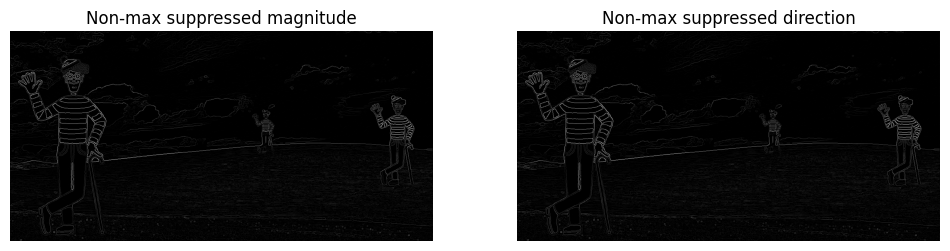

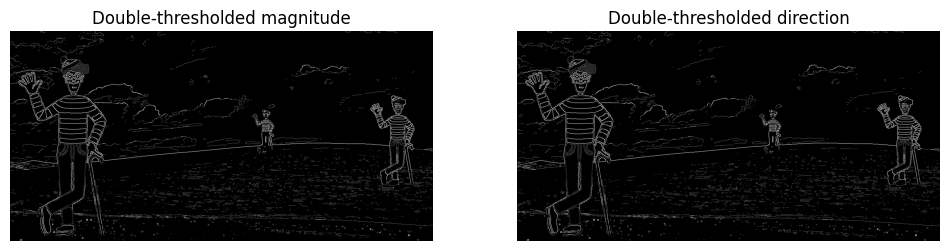

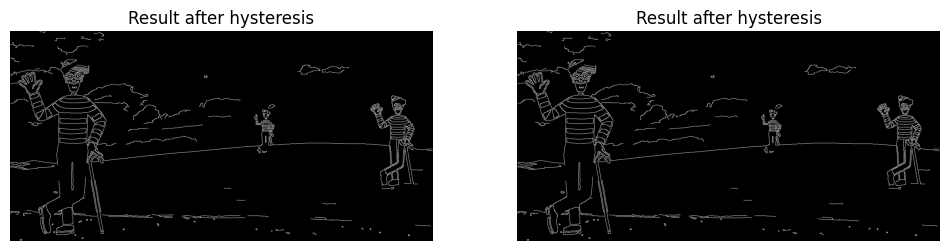

Step 0: Template Shape = (595, 295)


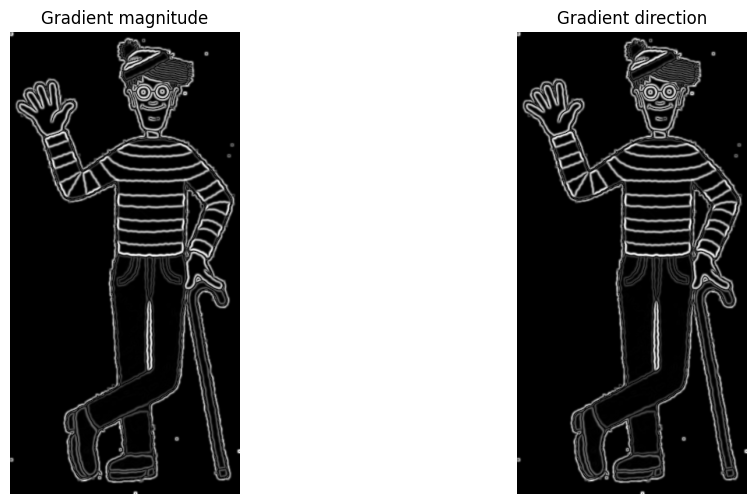

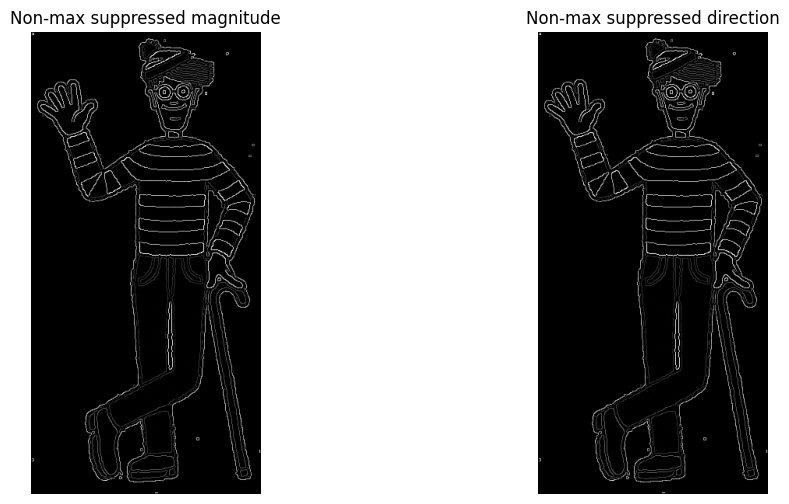

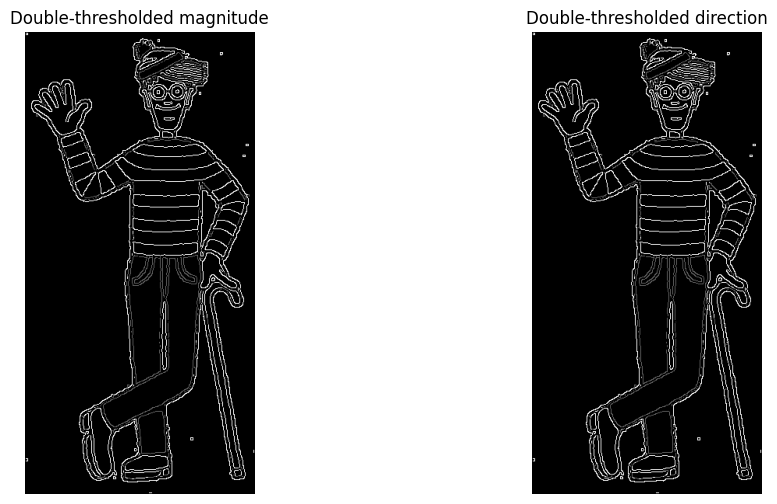

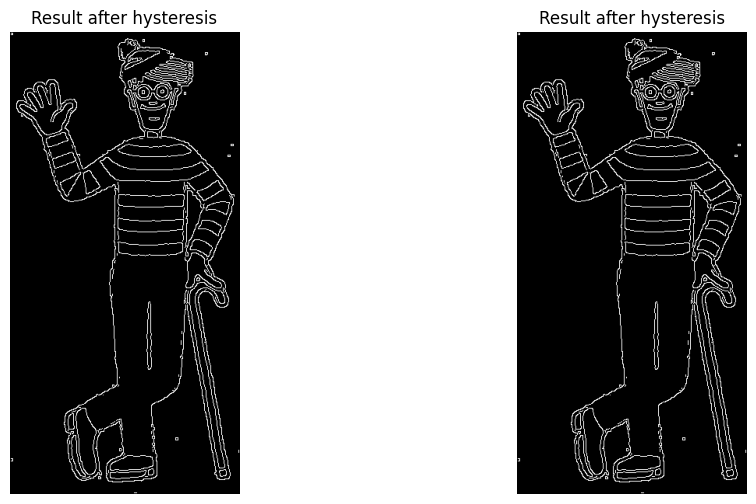

Step 0: Time for matching = 0.26 seconds


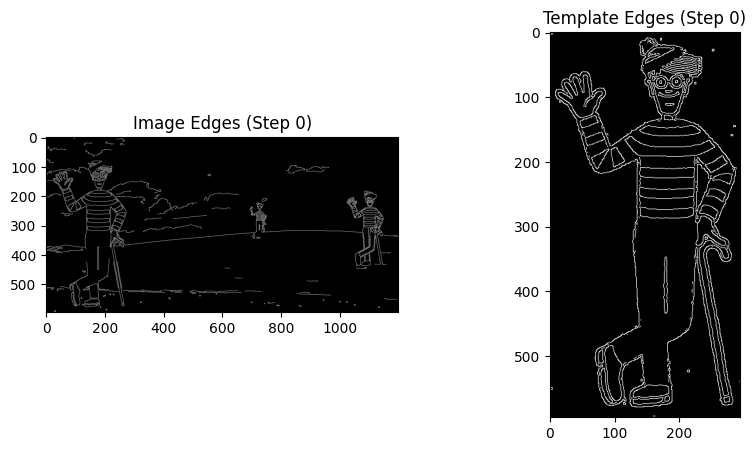

Step 1: Template Shape = (297, 147)


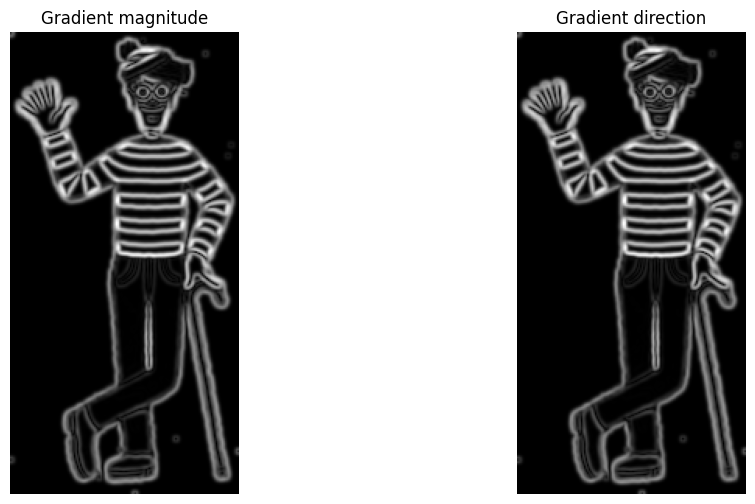

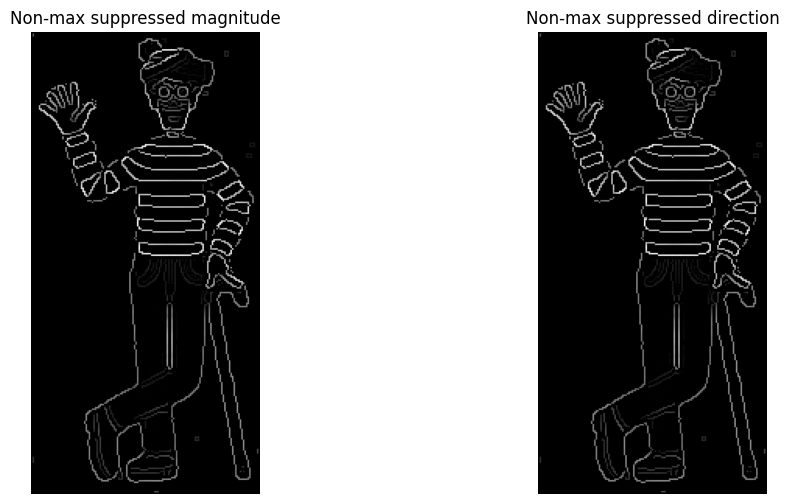

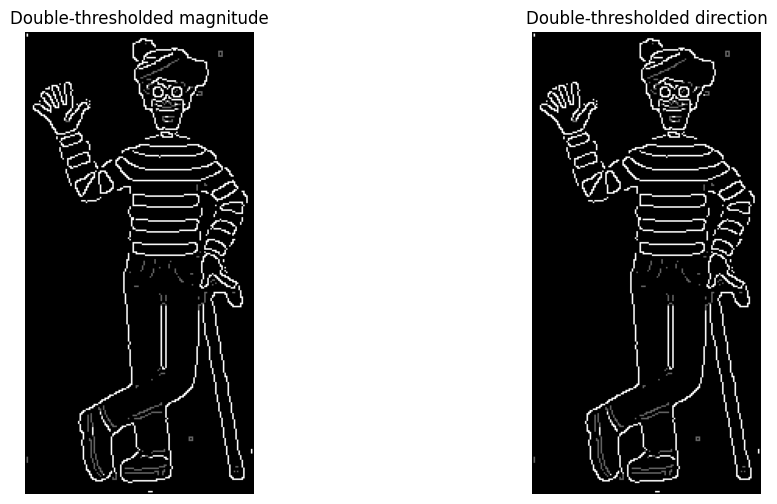

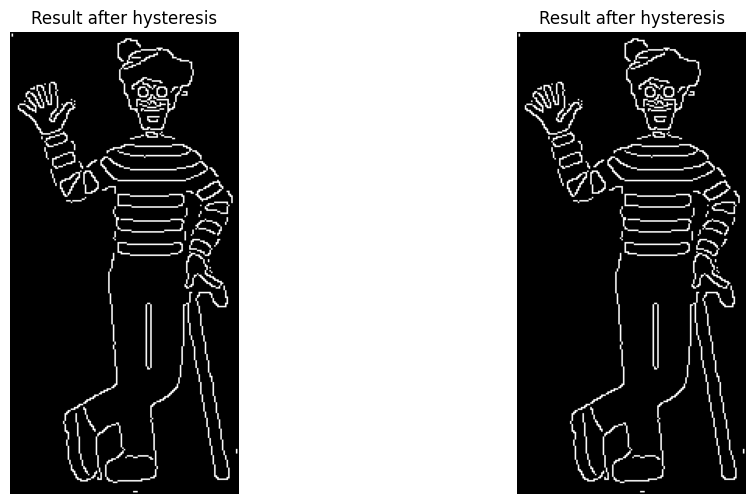

Step 1: Time for matching = 23.25 seconds


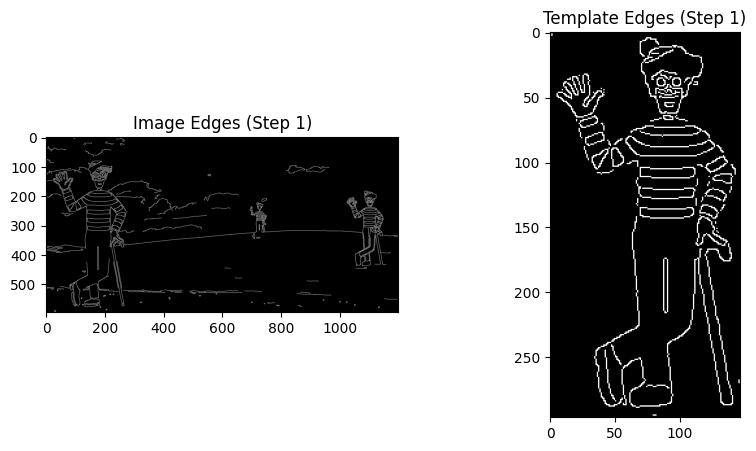

Step 2: Template Shape = (148, 73)


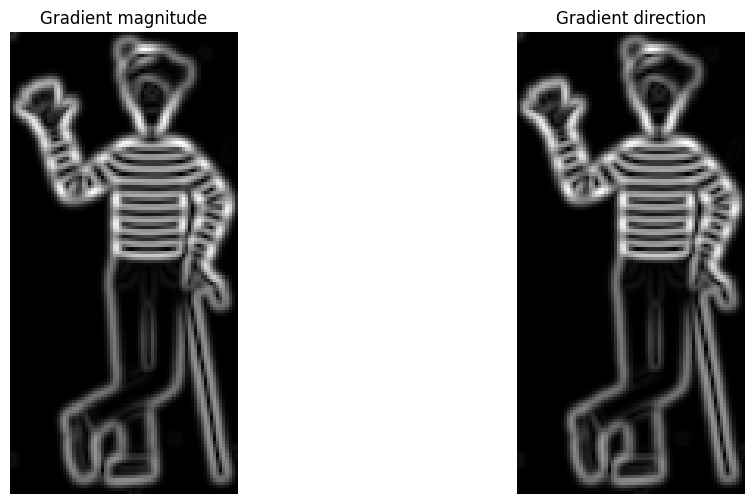

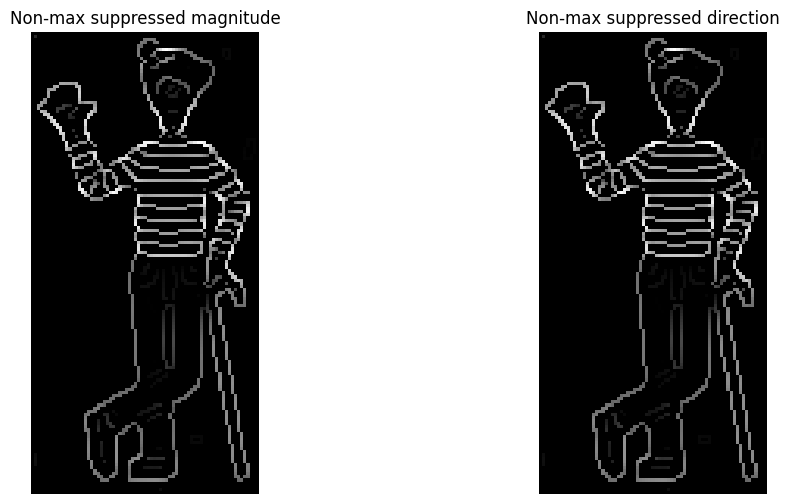

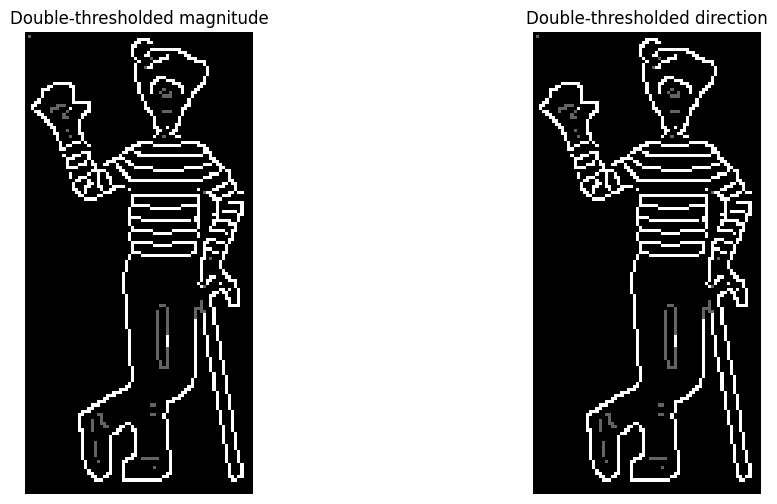

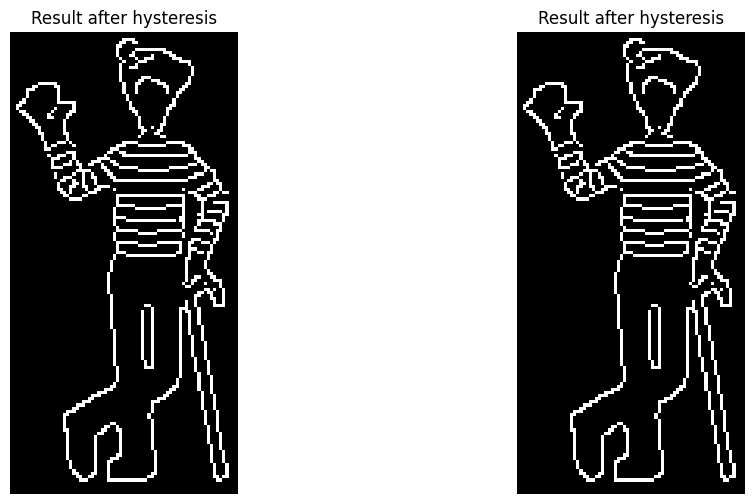

Step 2: Time for matching = 13.85 seconds


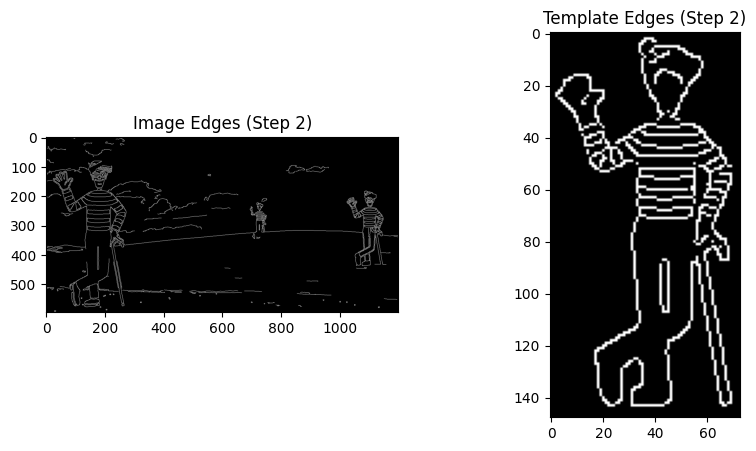

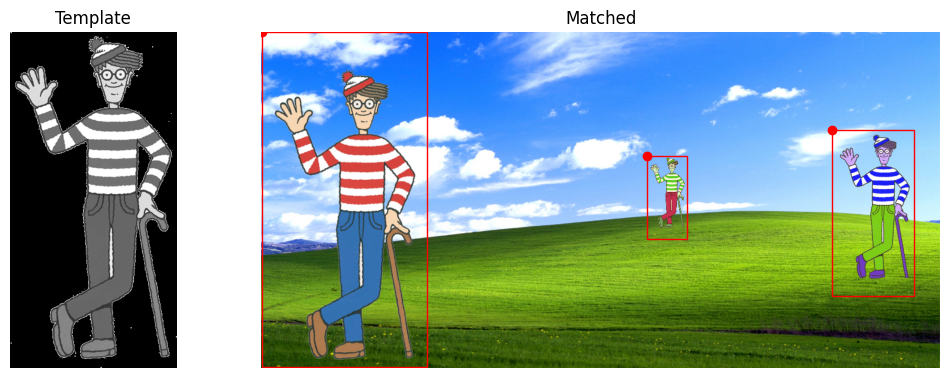

In [153]:
img1 = rgb2gray(np.array(Image.open("images/findwally.jpg")))
img2 = rgb2gray(np.array(Image.open("images/wally.jpg")))

multiscale_res = multi_scale_match_template(
    img=img1,
    template=img2,
    steps=2,
    sigma=1,
    low_threshold=30,
    high_threshold=70,
)


imgs = [img2, np.array(Image.open("images/findwally.jpg"))]
xlabels = [
    "Template",
    "Matched",
]
axs = plot_pictures(imgs, xlabels, 1, 2, show=False, vmin=None, vmax=None)

for d in multiscale_res:
    axs[-1].plot(d["result"][1], d["result"][0], "ro")
    axs[-1].add_patch(
        patches.Rectangle(
            (d["result"][1], d["result"][0]),
            d["template"].shape[1]-2,
            d["template"].shape[0]-2,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
    )
plt.show()